# IUM 25L - Projekt
AB Test

In [22]:
from sklearn.metrics import mean_absolute_error, accuracy_score, median_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests


from nocarz.config import PROCESSED_DATA_DIR, LOGS_DIR, HOST, PORT, NUMERICAL_TARGETS, CATEGORICAL_TARGETS
from nocarz.api.utils import get_microservice, test_connection, create_listing_request
from nocarz.src.advanced_model import AdvancedModel
from nocarz.src.base_model import BaseModel

### Preparing the data

In [23]:
test_data = pd.read_csv(PROCESSED_DATA_DIR / "test.csv")
test_data.shape

(552, 13)

### Running the AB Test

In [3]:
with get_microservice() as microservice:
    test_connection()

    for idx, row in test_data.iterrows():
        post_data = create_listing_request(row)

        try:
            response = requests.post(f"http://{HOST}:{PORT}/predict", data=post_data)
            response.raise_for_status()
        except requests.exceptions.HTTPError as err:
            print(f"Error processing row {idx}: {err}")

Server is running.


### Closing the microservice

In [4]:
try:
    test_connection()
except Exception as e:
    print(f"Microservice terminated.")
    print(e)

Microservice terminated.
HTTPConnectionPool(host='0.0.0.0', port=8080): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7a0489ec4040>: Failed to establish a new connection: [Errno 111] Connection refused'))


### Evaluating the results

In [24]:
logs = pd.read_csv(LOGS_DIR / "logs.csv")
logs.shape

(552, 13)

Base model

In [25]:
base_results = []

for idx, row in logs.iterrows():
    if row['model'] != 'base':
        continue

    id = row['id']
    actual_values = test_data[test_data['id'] == id].iloc[0]

    predictions = row[NUMERICAL_TARGETS + CATEGORICAL_TARGETS].to_dict()
    evaluation = BaseModel.evaluate_predictions(predictions, actual_values)

    result = {
        'listing_id': row['id'],
        'host_id': row['host_id'],
        'data_type': row['type'],
        'predictions': predictions,
        'evaluation': evaluation
    }
    base_results.append(result)

base_metrics = {}

for col in NUMERICAL_TARGETS:
    errors = []
    for result in base_results:
        if col in result['evaluation'] and result['evaluation'][col]['type'] == 'numerical':
            errors.append(result['evaluation'][col]['error'])

    if errors:
        base_metrics[col] = {
            'mean_absolute_error': np.mean(errors),
            'median_absolute_error': np.median(errors),
            'count': len(errors)
        }

for col in CATEGORICAL_TARGETS:
    matches = []
    for result in base_results:
        if col in result['evaluation'] and result['evaluation'][col]['type'] == 'categorical':
            matches.append(result['evaluation'][col]['match'])

    if matches:
        base_metrics[col] = {
            'accuracy': np.mean(matches),
            'count': len(matches)
        }

Advanced model

In [26]:
advanced_results = []

for idx, row in logs.iterrows():
    if row['model'] != 'advanced':
        continue

    id = row['id']
    actual_values = test_data[test_data['id'] == id].iloc[0]

    predictions = row[NUMERICAL_TARGETS + CATEGORICAL_TARGETS].to_dict()
    evaluation = AdvancedModel.evaluate_predictions(predictions, actual_values)

    result = {
        'listing_id': row['id'],
        'host_id': row['host_id'],
        'predictions': predictions,
        'evaluation': evaluation
    }
    advanced_results.append(result)

advanced_metrics = {}
pred_numerical = {col: [] for col in NUMERICAL_TARGETS}
true_numerical = {col: [] for col in NUMERICAL_TARGETS}
pred_categorical = {col: [] for col in CATEGORICAL_TARGETS}
true_categorical = {col: [] for col in CATEGORICAL_TARGETS}

for result in advanced_results:
    predictions = result['predictions']
    evaluation = result['evaluation']

    for col in NUMERICAL_TARGETS:
        if col in evaluation and evaluation[col]['type'] == 'numerical':
            pred_numerical[col].append(evaluation[col]['predicted'])
            true_numerical[col].append(evaluation[col]['actual'])

    for col in CATEGORICAL_TARGETS:
        if col in evaluation and evaluation[col]['type'] == 'categorical':
            pred_categorical[col].append(evaluation[col]['predicted'])
            true_categorical[col].append(evaluation[col]['actual'])

for col in NUMERICAL_TARGETS:
    if len(pred_numerical[col]) > 0:
        y_true = np.array(true_numerical[col])
        y_pred = np.array(pred_numerical[col])

        advanced_metrics[col] = {
            "mean_absolute_error": mean_absolute_error(y_true, y_pred),
            "median_absolute_error": median_absolute_error(y_true, y_pred),
            "count": len(y_true)
        }

for col in CATEGORICAL_TARGETS:
    if len(pred_categorical[col]) > 0:
        y_true = true_categorical[col]
        y_pred = pred_categorical[col]

        advanced_metrics[col] = {
            "accuracy": accuracy_score(y_true, y_pred),
            "count": len(y_true)
        }

### Comparing of the models

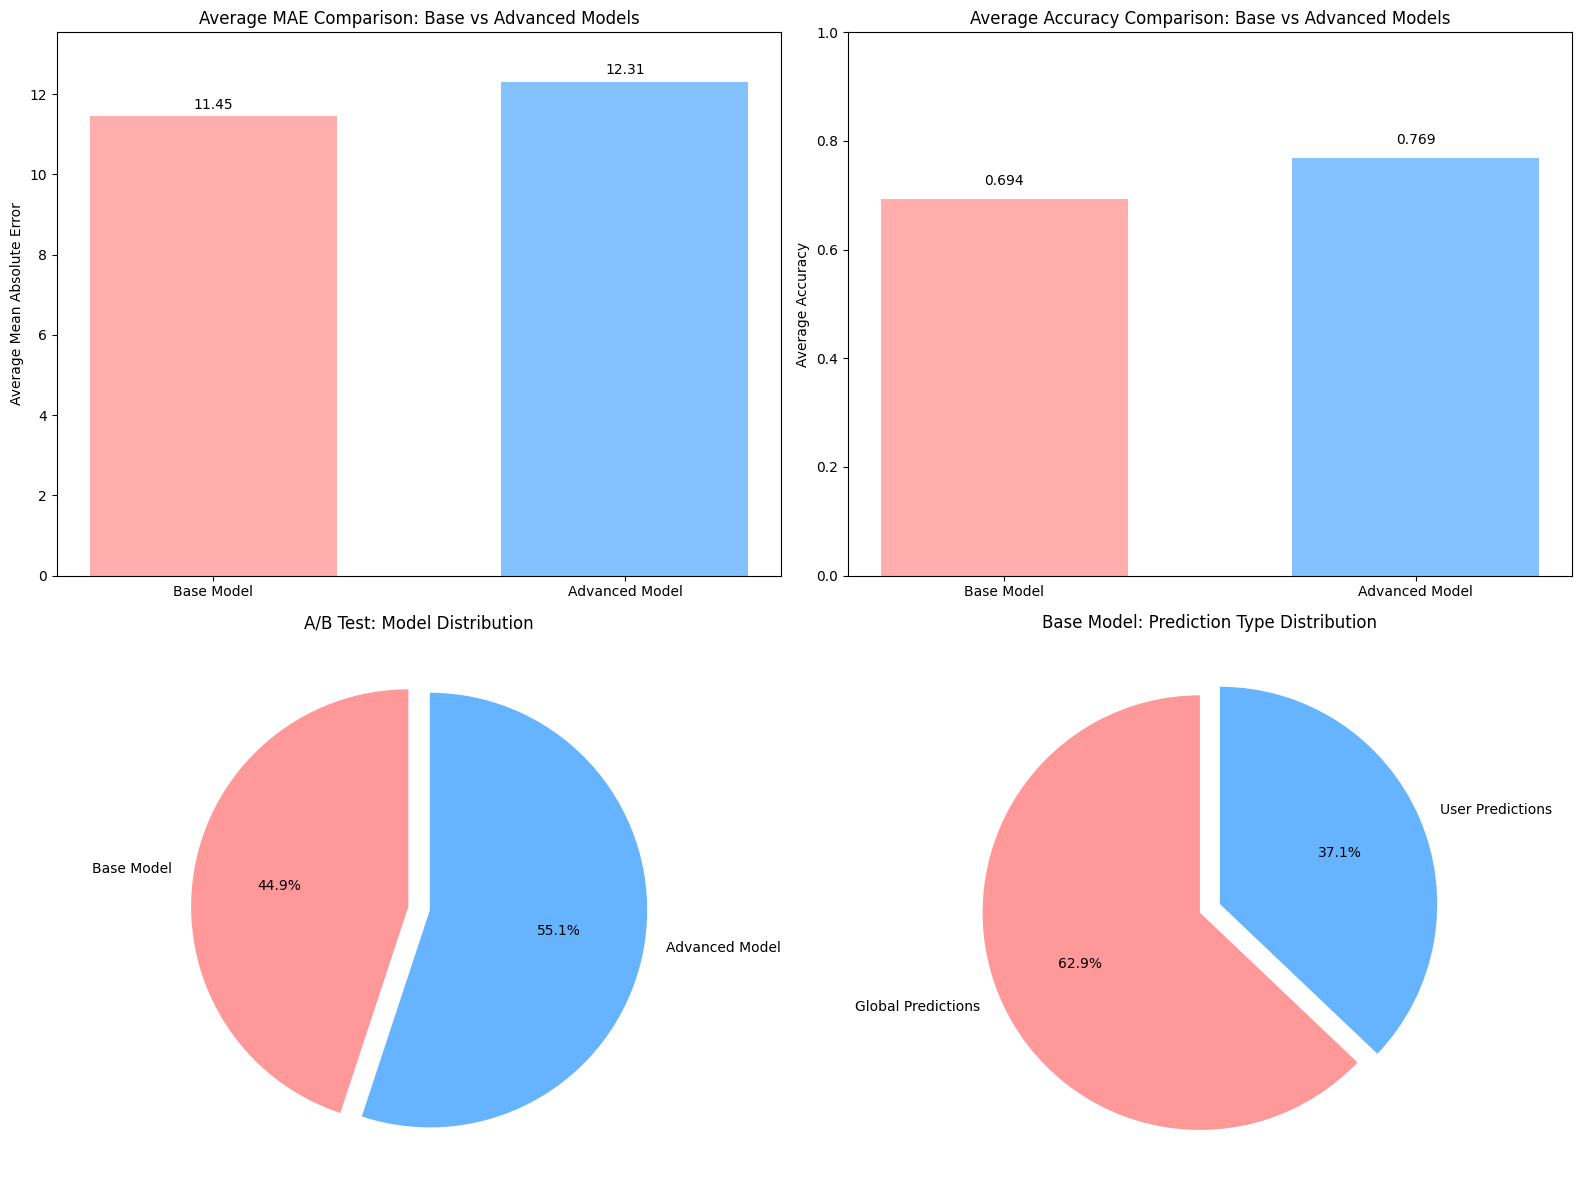


A/B TEST RESULTS SUMMARY
Total predictions: 552
Base model predictions: 248 (44.9%)
Advanced model predictions: 304 (55.1%)

Base model prediction types:
  Global predictions: 156 (62.9% of base)
  User predictions: 92 (37.1% of base)


In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
BLUE = '#66b3ff'
RED = '#ff9999'

# 1. MAE comparison for base and advanced models
base_mae = np.mean([base_metrics[col]['mean_absolute_error'] for col in NUMERICAL_TARGETS])
advanced_mae = np.mean([advanced_metrics[col]['mean_absolute_error'] for col in NUMERICAL_TARGETS])

models = ['Base Model', 'Advanced Model']
mae_values = [base_mae, advanced_mae]

bars1 = ax1.bar(models, mae_values, color=[RED, BLUE], alpha=0.8, width=0.6)
ax1.set_ylabel('Average Mean Absolute Error')
ax1.set_title('Average MAE Comparison: Base vs Advanced Models')
ax1.set_ylim(0, max(mae_values) * 1.1 if mae_values else 1)

for i, (bar, val) in enumerate(zip(bars1, mae_values)):
    if val > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., val + val*0.01, f'{val:.2f}', ha='center', va='bottom')

# 2. Accuracy comparison for base and advanced models
base_accuracy = np.mean([base_metrics[col]['accuracy'] for col in CATEGORICAL_TARGETS])
advanced_accuracy = np.mean([advanced_metrics[col]['accuracy'] for col in CATEGORICAL_TARGETS])
accuracy_values = [base_accuracy, advanced_accuracy]

bars2 = ax2.bar(models, accuracy_values, color=[RED, BLUE], alpha=0.8, width=0.6)
ax2.set_ylabel('Average Accuracy')
ax2.set_title('Average Accuracy Comparison: Base vs Advanced Models')
ax2.set_ylim(0, 1)

for i, (bar, val) in enumerate(zip(bars2, accuracy_values)):
    if val > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., val + 0.02, f'{val:.3f}', ha='center', va='bottom')

# 3. Pie chart of base vs advanced model predictions
base_count = (logs['model'] == 'base').sum()
advanced_count = (logs['model'] == 'advanced').sum()

sizes1 = [base_count, advanced_count]
labels1 = ['Base Model', 'Advanced Model']
colors1 = [RED, BLUE]

ax3.pie(sizes1, labels=labels1, colors=colors1, autopct='%1.1f%%', startangle=90, explode=(0.05, 0.05))
ax3.set_title('A/B Test: Model Distribution')

# 4. Pie chart of global vs user predictions for base model
base_logs = logs[logs['model'] == 'base']
base_global_count = (base_logs['type'] == 'global').sum()
base_user_count = (base_logs['type'] == 'user').sum()

sizes2 = [base_global_count, base_user_count]
labels2 = ['Global Predictions', 'User Predictions']
colors2 = [RED, BLUE]

ax4.pie(sizes2, labels=labels2, colors=colors2, autopct='%1.1f%%', startangle=90, explode=(0.05, 0.05))
ax4.set_title('Base Model: Prediction Type Distribution')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("A/B TEST RESULTS SUMMARY")
print("="*60)
print(f"Total predictions: {len(logs)}")
print(f"Base model predictions: {base_count} ({base_count/len(logs):.1%})")
print(f"Advanced model predictions: {advanced_count} ({advanced_count/len(logs):.1%})")

print(f"\nBase model prediction types:")
if base_count > 0:
    print(f"  Global predictions: {base_global_count} ({base_global_count/base_count:.1%} of base)")
    print(f"  User predictions: {base_user_count} ({base_user_count/base_count:.1%} of base)")
else:
    print("  No base predictions")